# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative

1. Importing required Libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayushibhasker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

2. Explaoratory Data Analysis

In [3]:
#Load the data

data = pd.read_csv("output.csv")
print(f"Dataset shape : {data.shape} ")

Dataset shape : (3150, 5) 


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [5]:
#Column names
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [6]:
#Check for null values
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
# Getting the record where 'verified_revies' is null
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [8]:
# We will drop the null record
data.dropna(inplace = True)

In [9]:
data.shape

(3149, 5)

In [10]:
# Creating a new column 'length' that will contain the length of the string in 'verified_reviews
data['length'] = data['verified_reviews'].apply(len)

In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [12]:
#Randomly checking for 10th record
print(f"'verified_reviwes' column value:{data.iloc[10]['verified_reviews']}")
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}")
print(f"'Length' column value : {data.iloc[10]['length']}")

'verified_reviwes' column value:I sent it to my 85 year old Dad, and he talks to it constantly.
Length of review : 63
'Length' column value : 63


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [13]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

- rating, feedback and length are integer values
- date, variation and verified_reviews are string values

# Analyzing 'rating' columns
this column refers to the rating of the variation given by the user


In [14]:
len(data)

3149

In [15]:
#Distinct values of 'rating' and its count
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

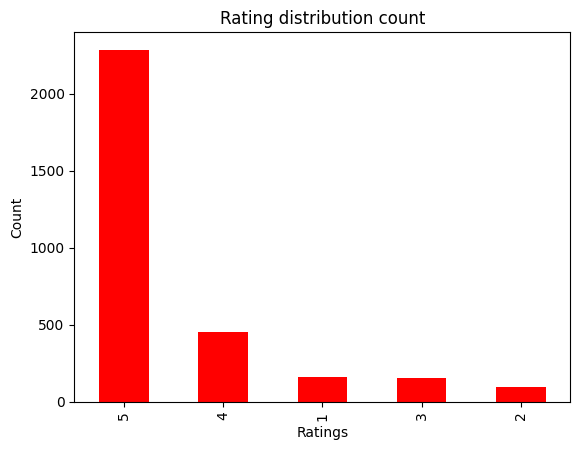

In [16]:
#Bar plot to visualize teh total counts of each rating
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [17]:
# Finding the percentage distribution of each rating - we'll divide the number of reviews
data['rating'].value_counts()/data.shape[0]*100,2

(rating
 5    72.594474
 4    14.449031
 1     5.112734
 3     4.826929
 2     3.016831
 Name: count, dtype: float64,
 2)

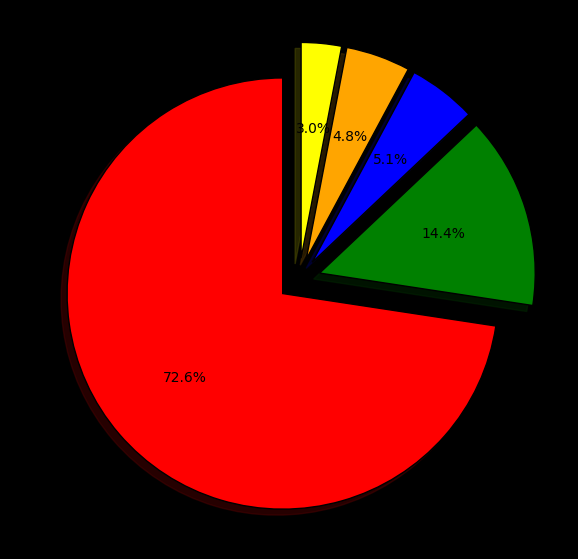

In [18]:
fig = plt.figure(figsize= (7,7))
colors = ('red','green','blue','orange','yellow')
wp = {'linewidth':1,"edgecolor":"black"}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%",shadow = True, colors = colors,startangle= 90,wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')
plt.gcf().set_facecolor("black")
from io import BytesIO
graph = BytesIO()
fig.savefig(graph,format="png")

# Analyzing 'feedback' column
This column refers to the feedback of the verified review

In [19]:
# Distinct values of 'feedback' and its count
data['feedback'].value_counts

<bound method IndexOpsMixin.value_counts of 0       1
1       1
2       1
3       1
4       1
       ..
3145    1
3146    1
3147    1
3148    1
3149    1
Name: feedback, Length: 3149, dtype: int64>

There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [20]:
# Extarcting the 'verified_reviews' value for one record with feedback = 0
review_0 = data[data['feedback'] == 0].iloc[50]['verified_reviews']
review_0

'Extremely low in volume'

In [21]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[8]['verified_reviews']
review_1

'looks great'

From the above 2 examples we can see that feedback 0 is negative review and 1 is positive review

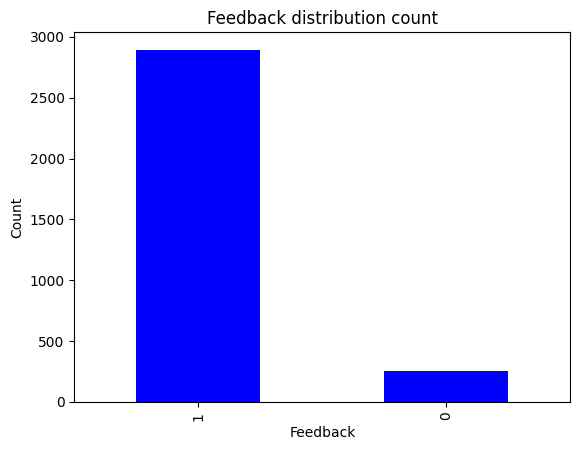

In [22]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [23]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records
data['feedback'].value_counts()/data.shape[0]*100,2

(feedback
 1    91.870435
 0     8.129565
 Name: count, dtype: float64,
 2)

Feedback distribution

- 91.87% reviews are positive


- 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

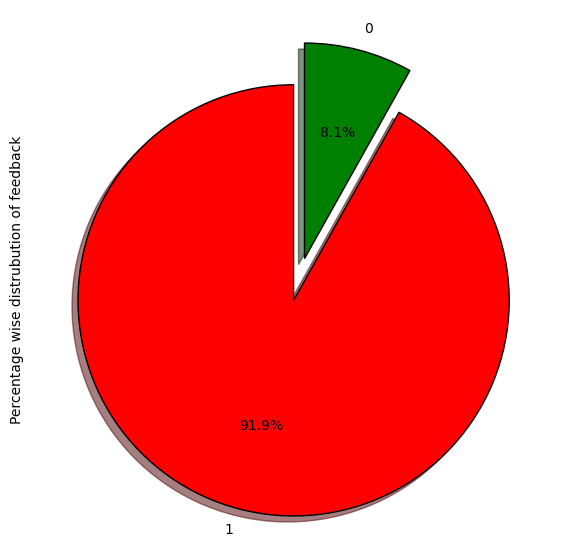

In [24]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')


In [25]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [26]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

# Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [27]:
#Distinct values of 'variation' and its count 
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

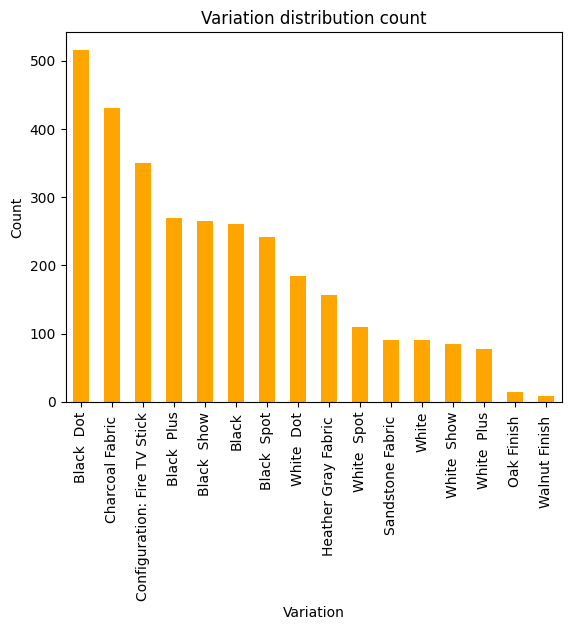

In [28]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [29]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records
data['variation'].value_counts()/data.shape[0]*100,2

(variation
 Black  Dot                      16.386154
 Charcoal Fabric                 13.655129
 Configuration: Fire TV Stick    11.114640
 Black  Plus                      8.574151
 Black  Show                      8.415370
 Black                            8.288346
 Black  Spot                      7.653223
 White  Dot                       5.843125
 Heather Gray Fabric              4.985710
 White  Spot                      3.461416
 Sandstone Fabric                 2.858050
 White                            2.858050
 White  Show                      2.699270
 White  Plus                      2.476977
 Oak Finish                       0.444586
 Walnut Finish                    0.285805
 Name: count, dtype: float64,
 2)

Mean rating according to variation

In [30]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

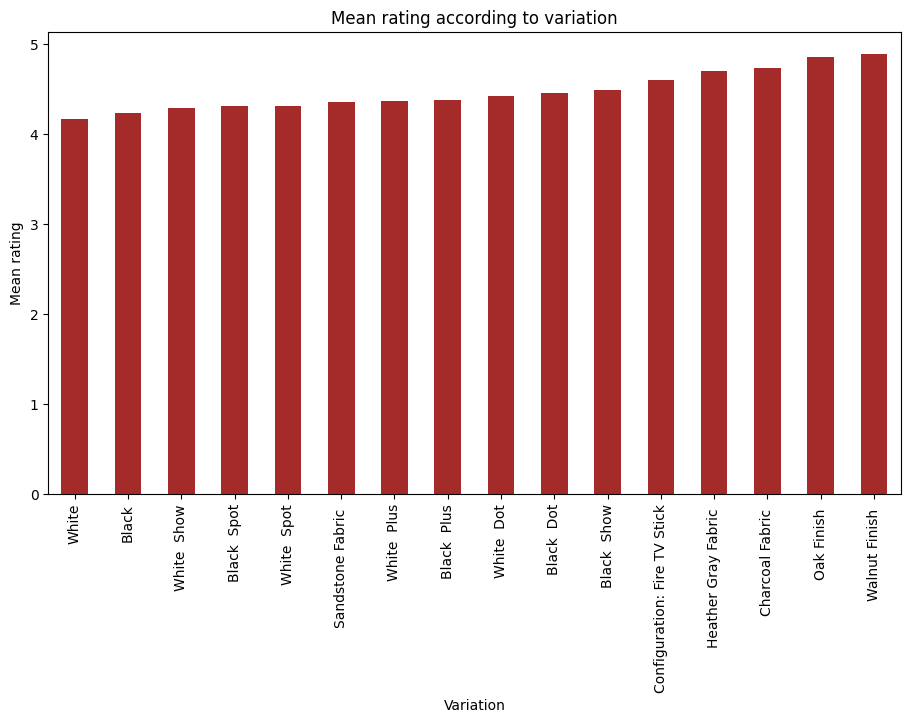

In [31]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

# Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [32]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

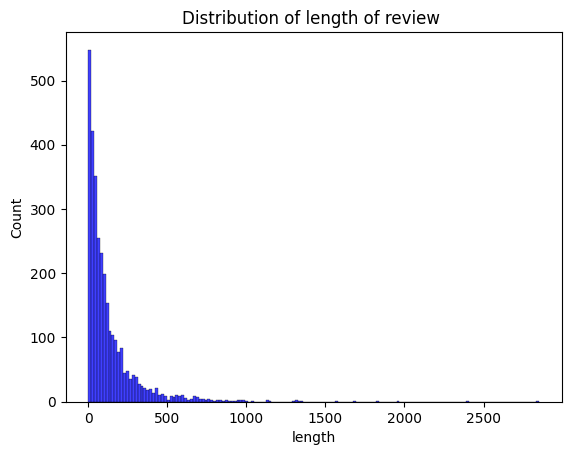

In [33]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

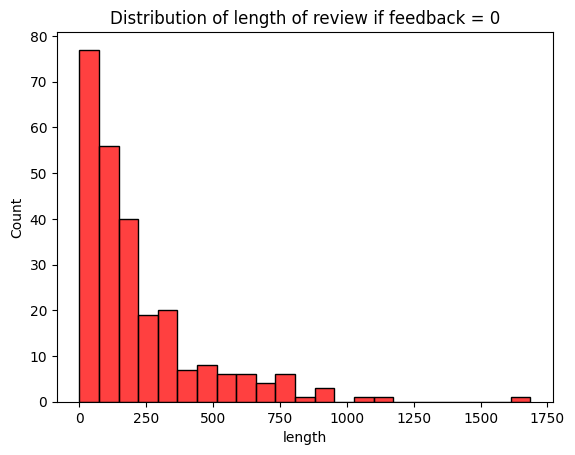

In [34]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

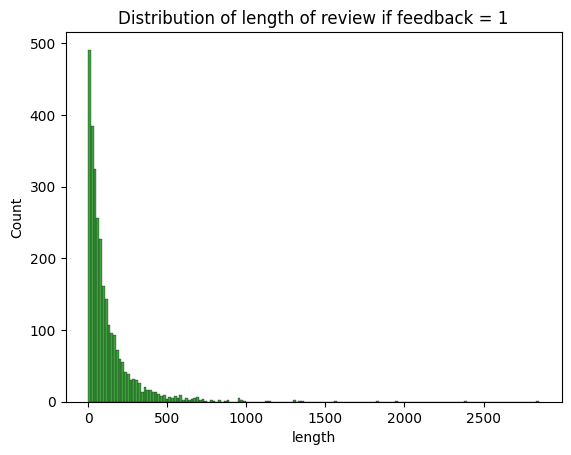

In [35]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

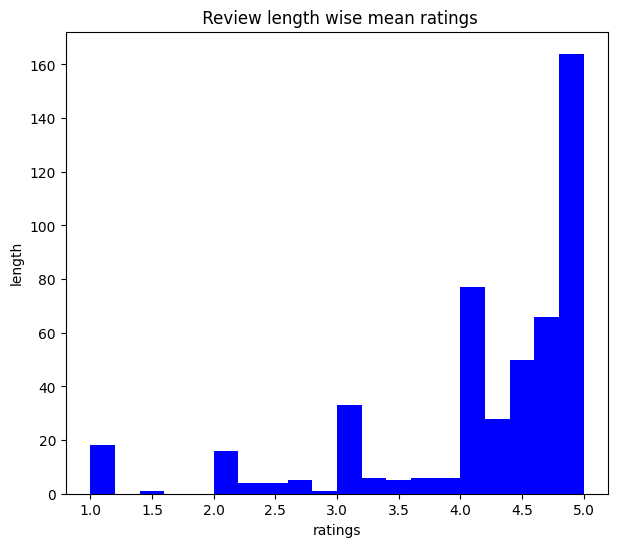

In [36]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [37]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

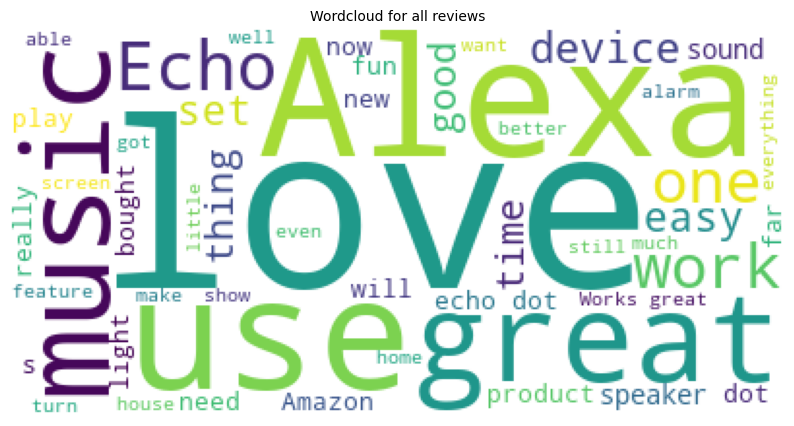

In [38]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [39]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

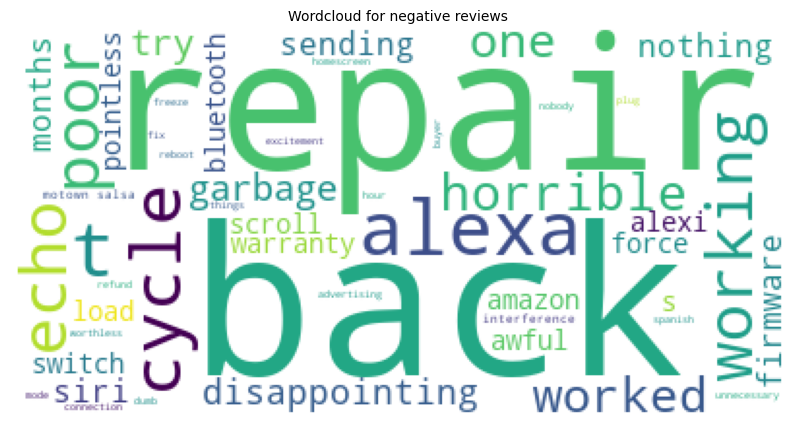

In [40]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

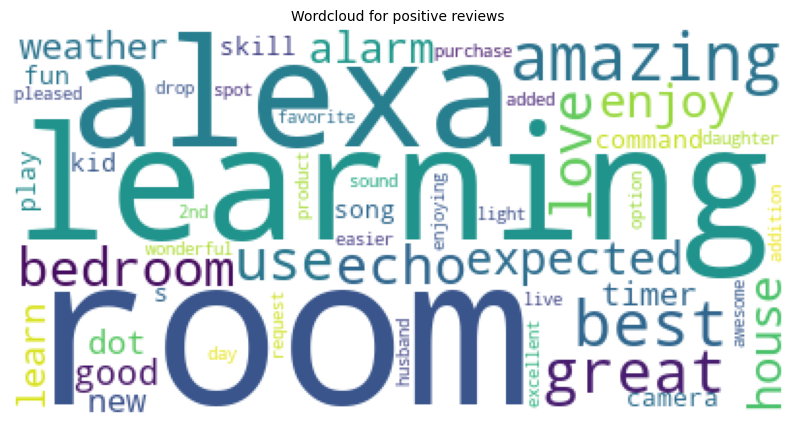

In [41]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# 3. Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following -

1.Replace any non alphabet characters with a space

2.Covert to lower case and split into words

3.Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [42]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [43]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [44]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [45]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [47]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [48]:
#Class Imbalance by Sampling Technique

from sklearn.datasets import make_classification
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


# Check class distribution before oversampling
print("Before oversampling:", Counter(y_train))

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Perform oversampling
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print("After oversampling:", Counter(y_resampled))

Before oversampling: Counter({1: 2026, 0: 178})
After oversampling: Counter({1: 2026, 0: 2026})


We'll scale X_train and X_test so that all values are between 0 and 1.

In [49]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [50]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# Using all models for train and test

In [57]:
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold
from sklearn.metrics import roc_curve,accuracy_score,f1_score,auc,confusion_matrix,roc_auc_score #,plot_confusion_matrix
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [58]:
import platform; print(platform.architecture())

('64bit', '')


In [59]:
# List of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),    ## BASIC BUT FAST BOOSTING TECHNIQUE
    'Bagging': BaggingClassifier(),
    'Extra Trees': ExtraTreesClassifier(),  ## TREE BASED CLASSIFIER
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),    ## SUPPORT VECTOR MACHINES
    'KNN': KNeighborsClassifier(),   ## K NEAREST NEIGHBOURS
    'Naive Bayes': GaussianNB()     ## PROBABILITY BASED APPROACH
}

# Dictionaries to store results
results_train = {}
results_test = {}

# K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    # Cross-validation
    cv_results = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
    results_train[name] = {
        'CrossVal_Score_Mean': cv_results.mean(),
        'CrossVal_Error': cv_results.std()
    }

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

    # Evaluate the predictions
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    clf_report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Store the evaluation metrics
    results_test[name] = {
        'Accuracy': accuracy,
        'F1_Score': f1,
        'ROC_AUC_Score': roc_auc,
        'Classification_Report': clf_report,
        'Confusion_Matrix': cm
    }

# Print the cross-validation results
for name, result in results_train.items():
    print(f"{name} (Training):")
    print(f"  CrossVal_Score_Mean: {result['CrossVal_Score_Mean']:.4f}")
    print(f"  CrossVal_Error: {result['CrossVal_Error']:.4f}")
    print()

# Print the test results
for name, result in results_test.items():
    print(f"{name} (Test):")
    print(f"  Accuracy: {result['Accuracy']:.4f}")
    print(f"  F1_Score: {result['F1_Score']:.4f}")
    print(f"  ROC_AUC_Score: {result['ROC_AUC_Score']}")
    print(f"  Classification_Report:\n{result['Classification_Report']}")
    print(f"  Confusion_Matrix:\n{result['Confusion_Matrix']}\n")

Logistic Regression (Training):
  CrossVal_Score_Mean: 0.9324
  CrossVal_Error: 0.0082

Random Forest (Training):
  CrossVal_Score_Mean: 0.9306
  CrossVal_Error: 0.0098

AdaBoost (Training):
  CrossVal_Score_Mean: 0.9251
  CrossVal_Error: 0.0086

Bagging (Training):
  CrossVal_Score_Mean: 0.9238
  CrossVal_Error: 0.0054

Extra Trees (Training):
  CrossVal_Score_Mean: 0.9333
  CrossVal_Error: 0.0135

Gradient Boosting (Training):
  CrossVal_Score_Mean: 0.9288
  CrossVal_Error: 0.0077

XGBoost (Training):
  CrossVal_Score_Mean: 0.9283
  CrossVal_Error: 0.0068

Decision Tree (Training):
  CrossVal_Score_Mean: 0.9142
  CrossVal_Error: 0.0102

SVM (Training):
  CrossVal_Score_Mean: 0.9220
  CrossVal_Error: 0.0094

KNN (Training):
  CrossVal_Score_Mean: 0.9192
  CrossVal_Error: 0.0090

Naive Bayes (Training):
  CrossVal_Score_Mean: 0.5640
  CrossVal_Error: 0.0151

Logistic Regression (Test):
  Accuracy: 0.9376
  F1_Score: 0.9667
  ROC_AUC_Score: 0.9202303847632568
  Classification_Report:
  

# Hpyer Parameter tuning

In [60]:
# Define the parameter grid for GridSeachCV
param_grid = {
    'n_estimators' : [50,100,200],
    'max_features' : ['auto','sqrt','log2'],
    'max_depth' : [10,20,30,None],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
    'bootstrap' : [True, False]
}
### 3*3*4*3*3*2*5 = 3240 fits

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,n_jobs=-1, scoring = 'accuracy', verbose = 2)

#Fit GridSeachCV
grid_search.fit(X_train, y_train)

#Get the beast parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total t

# Training the model with best hyper parameter

In [61]:
# Train the Random Forest model with the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = best_rf.predict(X_train)
y_train_pred_proba = best_rf.predict_proba(X_train)[:, 1]

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)
y_test_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_clf_report = classification_report(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_clf_report = classification_report(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print the evaluation metrics
print("Training Metrics:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1_Score: {train_f1:.4f}")
print(f"  ROC_AUC_Score: {train_roc_auc:.4f}")
print(f"  Classification_Report:\n{train_clf_report}")
print(f"  Confusion_Matrix:\n{train_cm}\n")

print("Test Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1_Score: {test_f1:.4f}")
print(f"  ROC_AUC_Score: {test_roc_auc:.4f}")
print(f"  Classification_Report:\n{test_clf_report}")
print(f"  Confusion_Matrix:\n{test_cm}\n")

Training Metrics:
  Accuracy: 0.9946
  F1_Score: 0.9970
  ROC_AUC_Score: 0.9985
  Classification_Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       178
           1       0.99      1.00      1.00      2026

    accuracy                           0.99      2204
   macro avg       1.00      0.97      0.98      2204
weighted avg       0.99      0.99      0.99      2204

  Confusion_Matrix:
[[ 166   12]
 [   0 2026]]

Test Metrics:
  Accuracy: 0.9429
  F1_Score: 0.9696
  ROC_AUC_Score: 0.9124
  Classification_Report:
              precision    recall  f1-score   support

           0       0.83      0.38      0.53        78
           1       0.95      0.99      0.97       867

    accuracy                           0.94       945
   macro avg       0.89      0.69      0.75       945
weighted avg       0.94      0.94      0.93       945

  Confusion_Matrix:
[[ 30  48]
 [  6 861]]



# Confusion Matrix

In [62]:
#Print the confusion matrix and slice it into four pieces
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_test_pred)
print('Confusion Matrix \n \n ',cm)

Confusion Matrix 
 
  [[ 30  48]
 [  6 861]]


In [63]:
print("True Positive : ", cm[1, 1])
print("True Negative : ", cm[0, 0])
print("False Positive: ", cm[0, 1])
print("False Negative: ", cm[1, 0])

True Positive :  861
True Negative :  30
False Positive:  48
False Negative:  6


<Axes: >

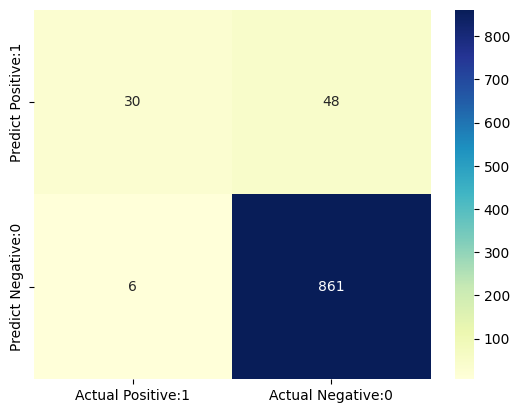

In [64]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
        index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Classification report

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.38      0.53        78
           1       0.95      0.99      0.97       867

    accuracy                           0.94       945
   macro avg       0.89      0.69      0.75       945
weighted avg       0.94      0.94      0.93       945

